[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DoranLyong/Awesome-Tensor-Architecture/blob/main/pytorch_reference/simple_reference/04_NN_Development_Reference/01_Image_Classification.ipynb)

# Image Classification with Transfer Learning - (refer to [pytorch tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html))

In [1]:
import numpy as np 

import torch 
import torch.nn as nn 
import torch.optim as optim 
from torch.utils.data import DataLoader
import torchvision 
from torchvision import datasets, models 
import torchvision.transforms as T 

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

## Data Processing (p.105)
* loading the data 
* transforms 
* dataloaders for batch sampling 

In [3]:
from io import BytesIO  
from urllib.request import urlopen 
from zipfile import ZipFile   # manipulate zip files on memory domain (ref) https://codesample-factory.tistory.com/1301

zipurl = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'


with urlopen(zipurl) as zipresp: 
    with ZipFile(BytesIO(zipresp.read())) as zfile: 
        zfile.extractall('./image_data')

In [4]:
# define transforms 

train_T = T.Compose([ T.RandomResizedCrop(224), 
                      T.RandomHorizontalFlip(), 
                      T.ToTensor(), 
                      T.Normalize( mean=[0.485, 0.456,0.406],
                                   std=[0.229, 0.224, 0.225])

                    ])

val_T = T.Compose([ T.Resize(256),
                    T.CenterCrop(224), 
                    T.ToTensor(), 
                    T.Normalize( mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
                  ])                    

In [5]:
# define your dataset objects 

train_dataset = datasets.ImageFolder(   root="./image_data/hymenoptera_data/train", 
                                        transform=train_T,
                                    )

val_dataset = datasets.ImageFolder( root="./image_data/hymenoptera_data/val",     
                                    transform=val_T,
                                  )                                                                      

In [6]:
# dataloaders for batch 

train_loader = DataLoader(  train_dataset, # dataset object 
                            batch_size=4, 
                            shuffle=True,
                            num_workers=4
                         )

val_loader = DataLoader( val_dataset, 
                         batch_size=4,
                         shuffle=True,
                         num_workers=4
                        )                         

## Model Design (p.107)
* modify the final layer to detect 2 classes instead of 1,000 (fine-tuning)

In [7]:
model = models.resnet18(pretrained=True)

print(model.fc) # final layer 
print(model.fc.in_features)

Linear(in_features=512, out_features=1000, bias=True)
512


In [8]:
# modify the layer 

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # fine-tune 

print(model.fc)

Linear(in_features=512, out_features=2, bias=True)


## Training and Validation (p.108)
* add a learning rate scheduler 

In [9]:
from torch.optim.lr_scheduler import StepLR

model = model.to(device)

criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(  model.parameters(), 
                        lr=1e-3, 
                        momentum=0.9,
                    )

# learning rate scheduler. 
exp_lr_scheduler = StepLR(  optimizer, # optim object 
                            step_size=7,
                            gamma=0.1
                        )

In [10]:
EPOCHS = 25 

for epoch in range(EPOCHS):

    # === Training === # 
    model.train() 
    train_loss = 0.0 
    train_acc = 0 
    
    for inputs, labels in train_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        # === forward 
        score = model(inputs)

        _, argmax_idx = torch.max(score, 1) 
        loss = criterion(score, labels) 

        # === backward 
        optimizer.zero_grad() 
        loss.backward() 



        # === gradient descent, and step 
        optimizer.step() 

        # === accumulate batch loss & accuracy 
        train_loss += loss.item() 
        train_acc += torch.sum(argmax_idx == labels.data) / float(inputs.size(0)) #
        

    # ---------------
    # Schedule the learning rate for next the epoch of training. 
    exp_lr_scheduler.step()     


    train_epoch_loss = train_loss / float( len(train_loader) )   # sum_batch_loss / step_size 
    train_epoch_acc = train_acc / float( len(train_loader) )   # num_corrects / (step_size * batch_size) 
                                                               # = tran_acc / step_size 


    # === Validation === # 
    model.eval() 
    val_loss = 0.0 
    val_acc = 0 

    for inputs, labels in val_loader:
        inputs = inputs.to(device)        
        labels = labels.to(device) 

        # === forward 
        score = model(inputs)

        _, argmax_idx = torch.max(score, 1)
        loss = criterion(score, labels)

        # === accumulate batch loss & accuracy 
        val_loss += loss.item()
        val_acc += torch.sum(argmax_idx == labels.data) / float(inputs.size(0)) 

    # -----------
    # Metrics 
    val_epoch_loss = val_loss / float( len(val_loader) )
    val_epoch_acc = val_acc / float( len(val_loader) )


    print(f"Epoch: {epoch} \n"
          f"Train Loss: {train_epoch_loss:.4f}, Acc: {train_epoch_acc:.4f} \n"
          f"Val Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.4f}"
        )        

/home/doranlyong/anaconda3/envs/py39/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0 
Train Loss: 0.6247, Acc: 0.7254 
Val Loss: 0.2330, Acc: 0.9231
Epoch: 1 
Train Loss: 0.4000, Acc: 0.8443 
Val Loss: 0.2405, Acc: 0.9231
Epoch: 2 
Train Loss: 0.5141, Acc: 0.8033 
Val Loss: 0.2791, Acc: 0.8846
Epoch: 3 
Train Loss: 0.4465, Acc: 0.8279 
Val Loss: 0.2368, Acc: 0.9167
Epoch: 4 
Train Loss: 0.4279, Acc: 0.8238 
Val Loss: 0.2831, Acc: 0.9167
Epoch: 5 
Train Loss: 0.4487, Acc: 0.8238 
Val Loss: 0.2279, Acc: 0.9167
Epoch: 6 
Train Loss: 0.5341, Acc: 0.7910 
Val Loss: 0.2791, Acc: 0.9231
Epoch: 7 
Train Loss: 0.2986, Acc: 0.8730 
Val Loss: 0.2647, Acc: 0.8974
Epoch: 8 
Train Loss: 0.2633, Acc: 0.8689 
Val Loss: 0.2629, Acc: 0.9295
Epoch: 9 
Train Loss: 0.2322, Acc: 0.9016 
Val Loss: 0.2683, Acc: 0.8910
Epoch: 10 
Train Loss: 0.4400, Acc: 0.7828 
Val Loss: 0.2730, Acc: 0.9103
Epoch: 11 
Train Loss: 0.2704, Acc: 0.8934 
Val Loss: 0.2466, Acc: 0.9295
Epoch: 12 
Train Loss: 0.2388, Acc: 0.8934 
Val Loss: 0.2262, Acc: 0.9423
Epoch: 13 
Train Loss: 0.3187, Acc: 0.8648 
Val 

## Testing and Deployment (p.111)

In [11]:
import matplotlib.pyplot as plt 


def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0)) # (C, H, W) -> (H, W, C) formats for plotting 

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # Undo the normalization we did during transforms so we can properly view images 
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)

    if title is not None:
        plt.title(title) 

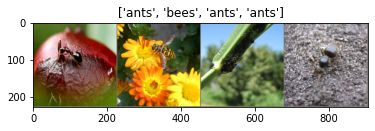

In [12]:
inputs, classes = next(iter(val_loader)) # Grab a batch of images from our validation dataset. 

out = torchvision.utils.make_grid(inputs)

class_names = val_dataset.classes

outputs = model(inputs.to(device)) # Perform classification using the fine-tuned ResNet-18 
_, argmax_idx = torch.max(outputs,1) # Take the maximum score's index for the winning class 

imshow(out, title=[class_names[x] for x in argmax_idx]) # Display the input images and their predicted classes.

## Save the model (p.112)  
* refer to ch.3 deployment 

In [15]:
torch.save(model.state_dict(), "./resnet18.pth")

In [20]:
# reload test 
model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2) 

model.load_state_dict( torch.load("./resnet18.pth"))

reload_model = model.to(device)

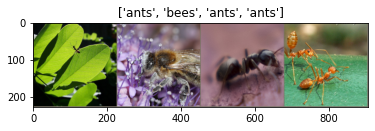

In [23]:
inputs, classes = next(iter(val_loader)) 

out = torchvision.utils.make_grid(inputs)

class_names = val_dataset.classes

outputs = reload_model(inputs.to(device)) 
_, argmax_idx = torch.max(outputs,1)

imshow(out, title=[class_names[x] for x in argmax_idx])